In [1]:
import pandas as pd
import numpy as np
from scipy import io
import time

## Loading filmtrust Dataset

In [2]:
rating_data = pd.read_csv('./datasets/ratings_data.txt', sep=' ')
trust_data = pd.read_csv('./datasets/trust_data.txt', sep=' ')


In [3]:
rating_data.dropna(inplace=True)
trust_data.dropna(inplace=True)


In [4]:
rating_data = rating_data.astype(int)
rating_data.head()


,user_id,item_id,rating_value
0,1,100,4
1,1,101,5
2,1,102,3
3,1,10,3
4,1,103,5


In [5]:
trust_data = trust_data.astype(int)
trust_data.head()


,source_user_id,target_user_id,trust_statement_value
0,22605,42915,1
1,22605,5052,1
2,22605,42913,1
3,22605,18420,1
4,22605,42914,1


## Loading epinion dataset

In [2]:
rating_mat = io.loadmat('./datasets/epinions/rating.mat')
trust_mat = io.loadmat('./datasets/epinions/trustnetwork.mat')
rating_data = pd.DataFrame(rating_mat['rating'], columns=['user_id','item_id', 'categoryid', 'rating_value'])
rating_data = rating_data[['user_id', 'item_id', 'rating_value']]
trust_data = pd.DataFrame(trust_mat['trustnetwork'], columns=['source_user_id', 'target_user_id'])


In [6]:
# np.random.randint(10, size=(40163, 1000)), np.random.randint(10, size=(139738, 1000))

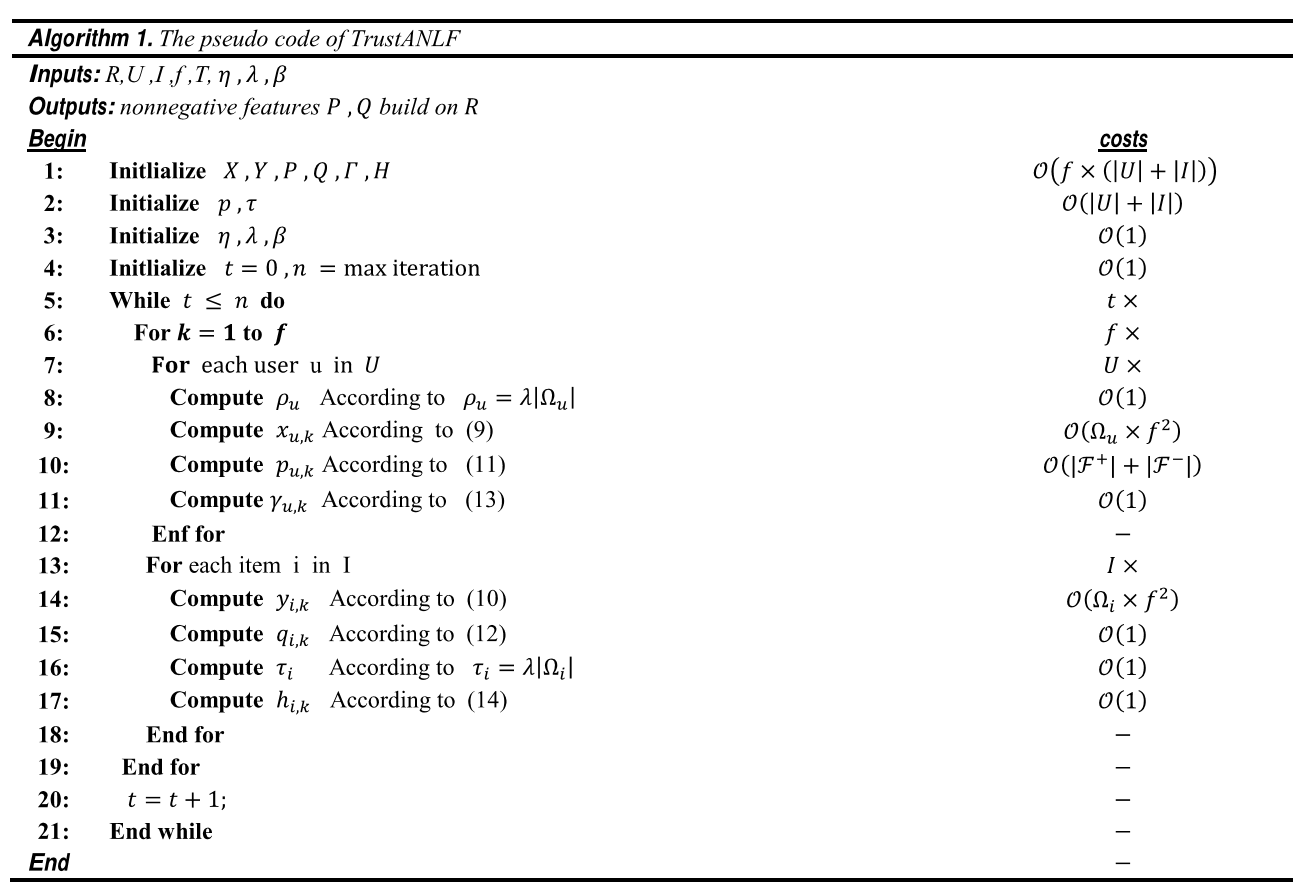

In [6]:
from IPython.display import Image
Image('algorithm.png', width=750)


## Initial Inputs

In [10]:
maxiteration = 1
f = 5
T = trust_data
R_user = rating_data.copy()
R_item = rating_data.copy()
U = rating_data.user_id.unique()
I = rating_data.item_id.unique()
P = np.random.uniform(size=(U.max(), f))
Q = np.random.uniform(size=(I.max(), f))
X = P.copy()
Y = Q.copy()
H = np.random.uniform(size=(I.max(), f))
GAMMA = np.random.uniform(size=(U.max(), f))
n = maxiteration
gamma = 0.001
lamda = 0.001
beta = 0.001
tau_all = rating_data.groupby('item_id').rating_value.sum() * lamda
rho_all = rating_data.groupby('user_id').rating_value.sum() * lamda


In [12]:
def pivot_user(R, u):
    if len(R.loc[u].shape) == 2:
        return pd.pivot_table(R.loc[u], values='rating_value', index='user_id', columns='item_id')
    else:
        return pd.pivot_table(pd.DataFrame({
                                 'user_id': u,
                                 'item_id': R.loc[u].item_id,
                                 'rating_value':R.loc[u].rating_value,}, 
                                 index=[0]), 
                             values='rating_value',
                             index='user_id', 
                             columns='item_id')

In [13]:
def pivot_item(R, i):
    if len(R.loc[i].shape) == 2:
        return pd.pivot_table(R.loc[i], values='rating_value', index='item_id', columns='user_id')
    else:
        return pd.pivot_table(pd.DataFrame({
                                'user_id': R.loc[i].user_id,
                                 'item_id': i,
                                 'rating_value':R.loc[i].rating_value,}, 
                                 index=[0]), 
                             values='rating_value',
                             index='item_id', 
                             columns='user_id')

In [14]:
def reset_user_index(R, u):
    if len(R_user.loc[u].shape) == 2:
        return R_user.loc[u].reset_index()   
    else:
        return pd.DataFrame({
                'user_id': u,
                'item_id': R_user.loc[u].item_id,
                'rating_value':R_user.loc[u].rating_value,
                }, 
                index=[0])

## Algorithm main loop

In [6]:
R_user.set_index('user_id', inplace=True)
R_item.set_index('item_id', inplace=True)
T.set_index('source_user_id', inplace=True)


In [17]:
time_start = time.time()
for _ in range(n):
    for k in range(f):
        for u in U:
            # compute rho_u
            rho = rho_all[u]
            
            # compute x_u,k
            ru = pivot_user(R_user, u)
            
            temp1 = 0
            temp2 = 0
            xuk = 0
            
            for i in pd.Series(R_user.item_id.loc[u]):
                temp2 += Y[i-1, k] ** 2
                for j in range(f):
                    if j != k:
                        temp1 += X[u-1, j] * Y[i-1, j]
                #xuk += Y[i, k] * (R_user.loc[u][R_user.loc[u].item_id == i].rating_value - temp1) 
                xuk += Y[i-1, k] * (ru[i] - temp1) 
            xuk += -GAMMA[u-1, k] + (rho * P[u-1, k])
            xuk = xuk / (temp2 + rho)
            X[u-1, k] = xuk
            
            # compute p_u,k
            
            temp3 = 0
            if u in T.index:
                for v in pd.Series(T.target_user_id.loc[u]):
                    if v in R_user.index:
                        temp4 = reset_user_index(R_user, v)
                        temp5 = reset_user_index(R_user, u)
                    
                        temp3 += pd.merge(temp5, 
                                          temp4, 
                                          how='outer', 
                                          on='item_id')[['rating_value_x', 'rating_value_y']].corr(min_periods=0).fillna(0).iloc[0, 1]
                        
                        temp3 *= P[v-1, k]

            for w in T[T.target_user_id == 1].index:
                temp4 = reset_user_index(R_user, w)
                temp5 = reset_user_index(R_user, u)
                
                temp3 += pd.merge(temp5, 
                                  temp4, 
                                  how='outer', 
                                  on='item_id')[['rating_value_x', 'rating_value_y']].corr(min_periods=0).fillna(0).iloc[0, 1]
                
                temp3 *= P[w-1, k]
                
            LAMBDA = GAMMA[u-1, k] + (rho * X[u-1, k]) + (beta * temp3)
            LAMBDA = LAMBDA / (rho + temp3)
            P[u-1, k] = max(0, LAMBDA)
            
            # compute gamma_u,k
            
            GAMMA[u-1, k] += gamma * rho * (X[u-1, k] - P[u-1, k]) 
        print(time.time())
        for i in I:
            # compute tau_i
            
            tau = tau_all[i]
            
            # compute y_i,k
            ri = pivot_item(R_item, i) 

            temp1 = 0
            temp2 = 0
            yik = 0 
            for u in pd.Series(R_item.user_id.loc[i]):
                temp2 += X[u-1, k] ** 2
                for j in range(f):
                    if k != j:
                        temp1 += X[u-1, j] * Y[i-1, j]
                yik += X[u-1, k] * (ri[u] - temp1) 
            yik += -H[i-1, k] + (tau * Q[i-1, k]) # mistake in addressing matrix Q with k and i
            yik = yik / (temp2 + tau)
            Y[i-1, k] = yik
            
            # ompute q_i,k
            
            Q[i-1, k] = max(0, Y[i-1, k] + (H[i-1, k] / tau))
            
            # compute taui
            # compute h_i,k
            H[i-1, k] += gamma * (Y[i-1, k] - Q[i-1, k])

time_end = time.time()

1680891738.4020185


KeyboardInterrupt: 

In [342]:
time_end - time_start 

1680878708.8648343

### compute Ru

In [ ]:
#             pd.pivot_table(R_user.loc[u], values='rating_value', index='user_id', columns='item_id') \
#             if len(R_user.loc[u].shape) == 2 else pd.pivot_table(
#                                                                  pd.DataFrame({
#                                                                      'user_id': u,
#                                                                      'item_id': R_user.loc[u].item_id,
#                                                                      'rating_value':R_user.loc[u].rating_value,}, 
#                                                                      index=[0]), 
#                                                                  values='rating_value',
#                                                                  index='user_id', 
#                                                                  columns='item_id')

### temp4_1

In [ ]:
#                         R_user.loc[v].reset_index() if len(R_user.loc[v].shape) == 2  else \
#                         pd.DataFrame({
#                                 'user_id': v,
#                                 'item_id': R_user.loc[v].item_id,
#                                 'rating_value':R_user.loc[v].rating_value,}, 
#                                 index=[0])

### temp5_1

In [ ]:
#                         R_user.loc[u].reset_index() if len(R_user.loc[u].shape) == 2  else \
#                         pd.DataFrame({
#                                 'user_id': u,
#                                 'item_id': R_user.loc[u].item_id,
#                                 'rating_value':R_user.loc[u].rating_value,}, 
#                                 index=[0])

### temp4_2

In [ ]:
#                 R_user.loc[w].reset_index() if len(R_user.loc[w].shape) == 2  else \
#                 pd.DataFrame({
#                         'user_id': w,
#                         'item_id': R_user.loc[w].item_id,
#                         'rating_value':R_user.loc[w].rating_value,}, 
#                         index=[0])

### temp5_2

In [ ]:
#                 R_user.loc[u].reset_index() if len(R_user.loc[u].shape) == 2  else \
#                 pd.DataFrame({
#                         'user_id': u,
#                         'item_id': R_user.loc[u].item_id,
#                         'rating_value':R_user.loc[u].rating_value,}, 
#                         index=[0])

### compute Ri

In [ ]:
#             pd.pivot_table(R_item.loc[i], values='rating_value', index='item_id', columns='user_id') \
#             if len(R_item.loc[i].shape) == 2 else pd.pivot_table(
#                                                                  pd.DataFrame({
#                                                                      'user_id': R_item.loc[i].user_id,
#                                                                      'item_id': i,
#                                                                      'rating_value':R_item.loc[i].rating_value,}, 
#                                                                      index=[0]), 
#                                                                  values='rating_value',
#                                                                  index='item_id', 
#                                                                  columns='user_id')